In [1]:
import psycopg2
import datetime
import numpy as np
import pandas as pd
from itertools import islice

from sklearn import preprocessing
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

from finance.utilities import utils
from finance.data_science.utilities import financial_utils, time_series_utils, cluster_utils, random_forest_utils

### Get stock data

In [4]:
query = """
    with raw as (
        select 
            market_datetime
            , symbol
            , sector
            , industry
            , (open + close) / 2 as average_price_today
            , volume
            , avg(open) over (partition by symbol order by market_datetime rows between 100 preceding and current row) as average_open_hundred_days
            , avg(open) over (partition by symbol order by market_datetime rows between 50 preceding and current row) as average_open_fifty_days
            , avg(open) over (partition by symbol order by market_datetime rows between 10 preceding and current row) as average_open_ten_days
            , max(open) over (partition by symbol order by market_datetime rows between 100 preceding and current row) as high_open_hundred_days
            , min(open) over (partition by symbol order by market_datetime rows between 100 preceding and current row) as low_open_hundred_days
            , avg(volume) over (partition by symbol order by market_datetime rows between 100 preceding and current row) as average_volume_hundred_days
            , avg(volume) over (partition by symbol order by market_datetime rows between 10 preceding and current row) as average_volume_ten_days
            , avg(open - close) over (partition by symbol order by market_datetime rows between 10 preceding and current row) as average_daily_finish_ten_days
            , avg(high - low) over (partition by symbol order by market_datetime rows between 10 preceding and current row) as average_daily_range_ten_days
            --, lead(open, 10) over (partition by symbol order by market_datetime) as open_ten_days_forward
            , avg(open) over (partition by symbol order by market_datetime rows between 5 following and 19 following) as forward_average
        from td.equities as equities
        left join nasdaq.listed_stocks as listed
            on listed.ticker = equities.symbol
        where market_datetime > '2019-01-01'
        and symbol in (select distinct ticker from nasdaq.listed_stocks limit 1000)
        )
    select * 
    from raw
    where forward_average is not null
    order by market_datetime
    """

df = utils.query_db(query=query)
df.head()

,market_datetime,symbol,sector,industry,average_price_today,volume,average_open_hundred_days,average_open_fifty_days,average_open_ten_days,high_open_hundred_days,low_open_hundred_days,average_volume_hundred_days,average_volume_ten_days,average_daily_finish_ten_days,average_daily_range_ten_days,forward_average
0,2019-01-02 06:00:00,NSL,None,None,5.525,155446.0,5.47,5.47,5.47,5.47,5.47,155446.0,155446.0,-0.11,0.1400,5.764000
1,2019-01-02 06:00:00,ORI,Finance,Property-Casualty Insurers,20.205,2153886.0,20.24,20.24,20.24,20.24,20.24,2153886.0,2153886.0,0.07,0.4224,20.848667
2,2019-01-02 06:00:00,NSL,None,None,5.525,155446.0,5.47,5.47,5.47,5.47,5.47,155446.0,155446.0,-0.11,0.1400,5.776667
3,2019-01-02 06:00:00,PACD,Energy,Oil & Gas Production,13.380,13046.0,12.82,12.82,12.82,12.82,12.82,13046.0,13046.0,-1.12,1.4300,14.736000
4,2019-01-02 06:00:00,ORN,Basic Industries,Military/Government/Technical,4.355,260490.0,4.26,4.26,4.26,4.26,4.26,260490.0,260490.0,-0.19,0.3500,4.886000


### Explore data

In [7]:
df['market_datetime_int'] = df['market_datetime'].astype(int)
df['diff'] = (df['forward_average'] - df['average_price_today'])/df['average_price_today']


categories = ['symbol', 'sector', 'industry']

for category in categories:
    one_hot_encoding = pd.get_dummies(df[category], prefix=category)
    df = df.join(one_hot_encoding)

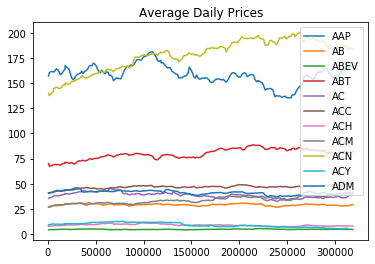

In [16]:
plt.plot()
plt.title('Average Daily Prices')

cnt = 0
for ticker, stock in df.groupby('symbol'):
    plt.plot(stock['average_price_today'], label=ticker)
    cnt += 1
    if cnt > 10:
        break
plt.legend()
plt.show()

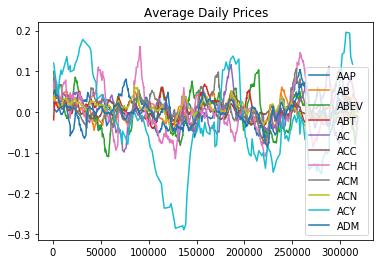

In [19]:
plt.plot()
plt.title('Average Daily Prices')

cnt = 0
for ticker, stock in df.groupby('symbol'):
    plt.plot(stock['diff'], label=ticker)
    cnt += 1
    if cnt > 10:
        break
plt.legend()
plt.show()

### Build random forest

#### Target: Open Price 10 Days from Now

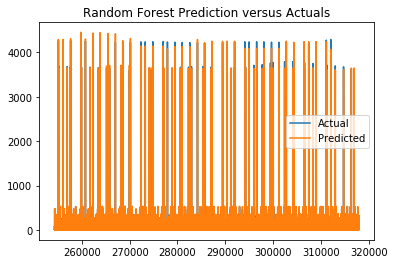

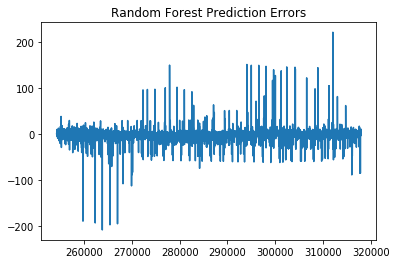

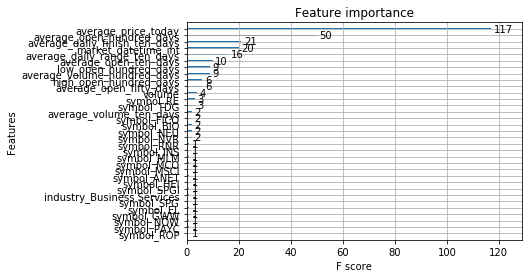

In [12]:
temp = df.copy()

x = temp.drop(['symbol', 'sector', 'industry', 'market_datetime', 'forward_average', 'diff'], axis=1)
y = temp.groupby('symbol')['forward_average'].shift(-1)

x = x[~y.isna()]
y = y[~y.isna()]

split = .8
cutoff = int(len(x) * .8)

train_x = x.iloc[:cutoff]
test_x = x.iloc[cutoff:]

train_y = y.iloc[:cutoff]
test_y = y.iloc[cutoff:]

boost = random_forest_utils.XGBooster(train_x=train_x, 
                                      train_y=train_y,
                                      test_x=test_x,
                                      test_y=test_y,
                                      objective='reg:squarederror',
                                      max_depth=2,
                                      n_estimators=100
                                     )

fit_model = boost.fit()
prediction = boost.predict(model=fit_model)
mse = boost.evaluate(prediction=prediction)

boost.plot_prediction(prediction)
boost.plot_prediction_error(prediction)
boost.plot_importance(model=fit_model)

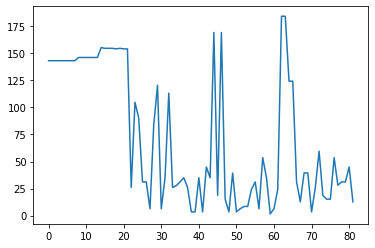

In [35]:
plt.plot(prediction[test_x[test_x['symbol_AAP']==1].index-min(test_x.index)])

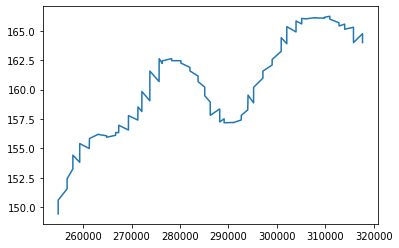

In [33]:
plt.plot(test_y[test_x[test_x['symbol_AAP']==1].index])

#### Target: 10 Day % Difference in Open Price

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


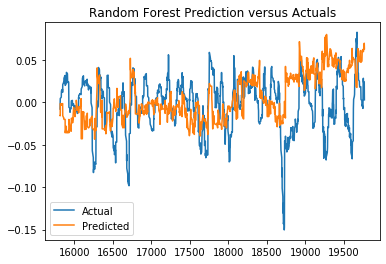

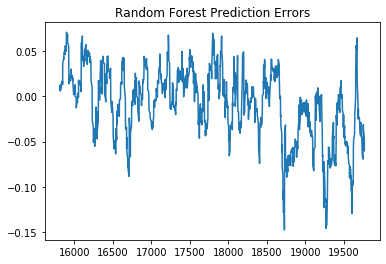

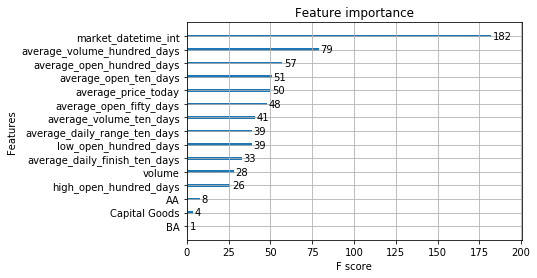

In [208]:
temp = df.copy()

x = temp.drop(['symbol', 'sector', 'industry', 'market_datetime', 'forward_average', 'diff'], axis=1)
y = temp.groupby('symbol')['diff'].shift(-1)

x = x[~y.isna()]
y = y[~y.isna()]

split = .8
cutoff = int(len(x) * .8)

train_x = x.iloc[:cutoff]
test_x = x.iloc[cutoff:]

train_y = y.iloc[:cutoff]
test_y = y.iloc[cutoff:]

boost_two = random_forest_utils.XGBooster(train_x=train_x, 
                                          train_y=train_y,
                                          test_x=test_x,
                                          test_y=test_y,
                                          objective='reg:squarederror',
                                          max_depth=3,
                                          n_estimators=100
                                     )

fit_model = boost_two.fit()
prediction = boost_two.predict(model=fit_model)
mse = boost_two.evaluate(prediction=prediction)

boost_two.plot_prediction(prediction)
boost_two.plot_prediction_error(prediction)
boost_two.plot_importance(model=fit_model)

In [134]:
query = """
    with raw as (
        select 
            market_datetime
            , symbol
            , lead(open) over (partition by symbol order by market_datetime rows between 5 following and 19 following) as forward_average
        from td.equities
        where market_datetime > '2010-01-01'
        and symbol in ('AA', 'BA', 'F', 'GA', 'AAPL', 'MSFT', 'MMM'))
    select * 
    from raw
    where forward_average is not null
    order by market_datetime
    """

df = utils.query_db(query=query)
df.head()

,market_datetime,symbol,average_price_today,volume,average_open_hundred_days,average_open_fifty_days,average_open_ten_days,high_open_hundred_days,low_open_hundred_days,average_volume_hundred_days,average_volume_ten_days,average_daily_finish_ten_days,average_daily_range_ten_days,forward_average
0,2010-01-04 06:00:00,MMM,83.055,3043663.0,83.090,83.090,83.090,83.09,83.09,3043663.0,3043663.0,0.070,0.780000,82.994000
1,2010-01-04 06:00:00,F,10.225,60855796.0,10.170,10.170,10.170,10.17,10.17,60855796.0,60855796.0,-0.110,0.234500,11.534667
2,2010-01-04 06:00:00,BA,55.950,6187088.0,55.720,55.720,55.720,55.72,55.72,6187088.0,6187088.0,-0.460,1.590000,60.364000
3,2010-01-04 06:00:00,AA,49.680,8629779.0,49.410,49.410,49.410,49.41,49.41,8629779.0,8629779.0,-0.540,1.469997,44.390000
4,2010-01-05 06:00:00,BA,57.135,8872728.0,55.985,55.985,55.985,56.25,55.72,7529908.0,7529908.0,-1.115,1.935000,60.320000


In [196]:
query = """
    with raw as (
    select 
        market_datetime
        , symbol
        , open
        , lead(open, 360) over (partition by symbol order by market_datetime rows between current row and unbounded following) as forward_open
    from td.equities
    where market_datetime > '2010-01-01'
    --and symbol in ('AA', 'BA', 'F', 'GA', 'AAPL', 'MSFT', 'MMM')
    limit 100000
    ),
    monthly as (
    select 
        symbol
        , extract('year' from market_datetime) as market_year
        , extract('month' from market_datetime) as market_month
        , avg((forward_open - open) / open) as percent_change
    from raw
    group by symbol, market_year, market_month
    ),
    stats as (
    select 
        symbol
            , avg(percent_change) as average_percent_change_yoy
            , stddev(percent_change) as standard_deviation_percent_change_yoy
    from monthly
    group by symbol
    )
    select 
        symbol
        , average_percent_change_yoy
        , standard_deviation_percent_change_yoy
    from stats
    where standard_deviation_percent_change_yoy is not null
    """

df = utils.query_db(query=query)
df.head()

,symbol,average_percent_change_yoy,standard_deviation_percent_change_yoy
0,ACV,0.105271,0.145044
1,ABR,0.226675,0.324252
2,ABC,0.215135,0.308504
3,ADM,0.084252,0.225936
4,AEF,-0.205380,0.361758


In [197]:
cluster_utils.KMeans(df['average_percent_change_yoy'], n_clusters=20).predicted_clusters

array([ 6, 13, 15, 19,  7, 16,  4, 12, 14, 10, 16,  6, 15,  6,  0,  2, 14,
        3, 19, 17,  3, 18,  3, 19,  1, 12, 18,  0, 10, 11, 15,  3, 11, 19,
       14,  9,  6, 13, 14,  8, 18, 18, 11, 15,  5,  8, 15], dtype=int32)

In [191]:
cluster_utils.KMeans(df.loc[df['symbol']=='BA', 'average_price_today'], n_clusters=20).predicted_clusters

array([7, 7, 7, ..., 6, 6, 6], dtype=int32)